In [29]:
import pandas
import matplotlib
from matplotlib import pyplot as plt
import seaborn
import numpy as np
import gc
%matplotlib inline

## Load Datasets

In [2]:
aisles = pandas.read_csv('aisles.csv')
dep = pandas.read_csv('departments.csv')
ord_prd_pr = pandas.read_csv('order_products__prior.csv')
ord_prd_tr = pandas.read_csv('order_products__train.csv')
orders = pandas.read_csv('orders.csv')
products = pandas.read_csv('products.csv')

In [31]:
train_user = pandas.read_csv('capstone-train-user_ids.csv')
test_user = pandas.read_csv('capstone-test-user_ids.csv')

In [5]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [6]:
dep.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [7]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [38]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [9]:
orders[['order_id', 'eval_set']].groupby('eval_set').count()

,order_id
eval_set,
prior,3214874
test,75000
train,131209


In [32]:
train_user.columns = ['user_id']
train_user[:3]

,user_id
0,2
1,5
2,8


In [33]:
test_user.columns = ['user_id']
test_user[:3]

,user_id
0,126694
1,61930
2,22291


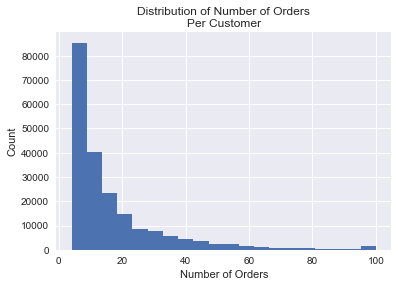

In [27]:
#get distribution of number of orders per customer
customerNumOrderFrame = orders.groupby("user_id",
                                        as_index = False)["order_number"].max()
plt.hist(customerNumOrderFrame["order_number"], bins=20)
plt.xlabel("Number of Orders")
plt.ylabel("Count")
plt.title("Distribution of Number of Orders\nPer Customer")

## Explore products, aisles, and departments

In [18]:
prod_all = pandas.merge(products, aisles, how='inner', left_on='aisle_id', right_on='aisle_id')
prod_all = pandas.merge(prod_all, dep, \
                            how='inner', left_on='department_id', right_on='department_id')
prod_all.head()

,product_id,product_name,aisle_id,department_id,aisle,department
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
1,78,Nutter Butter Cookie Bites Go-Pak,61,19,cookies cakes,snacks
2,102,Danish Butter Cookies,61,19,cookies cakes,snacks
3,172,Gluten Free All Natural Chocolate Chip Cookies,61,19,cookies cakes,snacks
4,285,Mini Nilla Wafers Munch Pack,61,19,cookies cakes,snacks


In [22]:
# number of products in each aisle
prod_group = prod_all['product_name'].groupby(prod_all['aisle']).count()
prod_group.sort_values(ascending=False).head()

aisle
missing                 1258
candy chocolate         1246
ice cream ice           1091
vitamins supplements    1038
yogurt                  1026
Name: product_name, dtype: int64

In [23]:
# Group the full dataframe by department & aisle.
ais_group = prod_all.groupby(['department','aisle']).size().reset_index().rename(columns={0:'count'})
# Group the grouped dataframe by department to get aisle count.
dep_group = ais_group['aisle'].groupby(ais_group['department']).count()
dep_group

department
alcohol             5
babies              4
bakery              5
beverages           8
breakfast           4
bulk                2
canned goods        5
dairy eggs         10
deli                5
dry goods pasta     5
frozen             11
household          10
international       4
meat seafood        7
missing             1
other               1
pantry             12
personal care      17
pets                2
produce             5
snacks             11
Name: aisle, dtype: int64

## Explore product, department, and aisle data

In [25]:
order_prod_all = pandas.merge(ord_prd_pr, prod_all, how='inner', left_on='product_id', right_on='product_id')
order_prod_all.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs
1,26,33120,5,0,Organic Egg Whites,86,16,eggs,dairy eggs
2,120,33120,13,0,Organic Egg Whites,86,16,eggs,dairy eggs
3,327,33120,5,1,Organic Egg Whites,86,16,eggs,dairy eggs
4,390,33120,28,1,Organic Egg Whites,86,16,eggs,dairy eggs


In [26]:
# Add a column to count the number of products in each order.
order_prod_all['product_count'] = order_prod_all.groupby('order_id')['order_id'].transform('count')

# Now add a column to find the maximum 'add_to_cart_order' order for each order.
order_prod_all['add_to_cart_max'] = order_prod_all.groupby('order_id')['add_to_cart_order'].transform('max')

# Add a column to check if these values match.
order_prod_all['match'] = np.where(order_prod_all['product_count']==order_prod_all['add_to_cart_max'],
                                          True, False)
order_prod_all.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,product_count,add_to_cart_max,match
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,9,9,True
1,26,33120,5,0,Organic Egg Whites,86,16,eggs,dairy eggs,8,8,True
2,120,33120,13,0,Organic Egg Whites,86,16,eggs,dairy eggs,16,16,True
3,327,33120,5,1,Organic Egg Whites,86,16,eggs,dairy eggs,8,8,True
4,390,33120,28,1,Organic Egg Whites,86,16,eggs,dairy eggs,34,34,True


In [28]:
# Now check to see if all match values are True.
order_prod_all['match'].unique()

array([ True], dtype=bool)

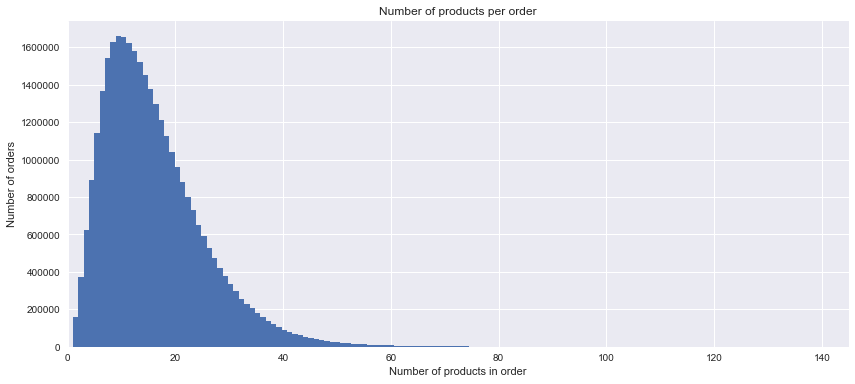

In [30]:
number_bins = order_prod_all['product_count'].max()
plt.figure(num=1,figsize=(14,6))
plt.hist(order_prod_all['product_count'], bins=number_bins)
plt.xlabel('Number of products in order')
plt.ylabel('Number of orders')
plt.title('Number of products per order')
plt.ticklabel_format(style='plain')
plt.xlim(0,number_bins)
plt.show()

In [56]:
del order_prod_all
del prod_all
gc.collect()

48622

In [35]:
products.dtypes

product_id         int64
product_name    category
department        object
aisle             object
dtype: object

## Data Preparing

In [3]:
aisles['aisle'] = aisles['aisle'].astype('category')
dep['department'] = dep['department'].astype('category')
orders['eval_set'] = orders['eval_set'].astype('category')
products['product_name'] = products['product_name'].astype('category')

orders.order_dow = orders.order_dow.astype(np.int8)
orders.order_hour_of_day = orders.order_hour_of_day.astype(np.int8)
orders.order_number = orders.order_number.astype(np.int16)
orders.order_id = orders.order_id.astype(np.int32)
orders.user_id = orders.user_id.astype(np.int32)
orders.days_since_prior_order = orders.days_since_prior_order.astype(np.float32)

products.aisle_id = products.aisle_id.astype(np.int8)
products.department_id = products.department_id.astype(np.int8)
products.product_id = products.product_id.astype(np.int32)

ord_prd_tr.reordered = ord_prd_tr.reordered.astype(np.int8)
ord_prd_tr.add_to_cart_order = ord_prd_tr.add_to_cart_order.astype(np.int16)

ord_prd_pr.order_id = ord_prd_pr.order_id.astype(np.int32)
ord_prd_pr.add_to_cart_order = ord_prd_pr.add_to_cart_order.astype(np.int16)
ord_prd_pr.reordered = ord_prd_pr.reordered.astype(np.int8)
ord_prd_pr.product_id = ord_prd_pr.product_id.astype(np.int32)

In [4]:
frames = [products, dep, aisles] # merge together of 3

products.dtypes

products = pandas.concat(frames, axis = 1)
products.drop(['department_id'], axis = 1, inplace = True)
products.drop(['aisle_id'], axis = 1, inplace = True)

ord_prd_tr = ord_prd_tr.merge(orders[['user_id','order_id']], how = 'inner', left_on = 'order_id', right_on = 'order_id')

orders_products = orders.merge(ord_prd_pr, how = 'inner', on = 'order_id')

prod_sort = orders_products.sort_values(['user_id', 'order_number', 'product_id'], ascending=True)

prod_sort = prod_sort.assign(product_time = prod_sort.groupby(['user_id', 'product_id']).cumcount()+1)

sub1 = prod_sort[prod_sort['product_time'] == 1].groupby('product_id').size().to_frame('prod_first_orders')
sub2 = prod_sort[prod_sort['product_time'] == 2].groupby('product_id').size().to_frame('prod_second_orders')

sub1['prod_orders'] = prod_sort.groupby('product_id')['product_id'].size()
sub1['prod_reorders'] = prod_sort.groupby('product_id')['reordered'].sum()
sub2 = sub2.reset_index().merge(sub1.reset_index())

sub2['prod_reorder_probability'] = sub2['prod_second_orders']/sub2['prod_first_orders']
sub2['prod_reorder_times'] = 1 + sub2['prod_reorders']/sub2['prod_first_orders']
sub2['prod_reorder_ratio'] = sub2['prod_reorders']/sub2['prod_orders']
prd = sub2[['product_id', 'prod_orders','prod_reorder_probability', 'prod_reorder_times', 'prod_reorder_ratio']]

users = orders[orders['eval_set'] == 'prior'].groupby(['user_id'])['order_number'].max().to_frame('user_orders')
users['user_period'] = orders[orders['eval_set'] == 'prior'].groupby(['user_id'])['days_since_prior_order'].sum()
users['user_mean_days_since_prior'] = orders[orders['eval_set'] == 'prior'].groupby(['user_id'])['days_since_prior_order'].mean()

user_all = orders_products.groupby('user_id').size().to_frame('user_total_products')
user_all['eq_1'] = orders_products[orders_products['reordered'] == 1].groupby('user_id')['product_id'].size()
user_all['gt_1'] = orders_products[orders_products['order_number'] > 1].groupby('user_id')['product_id'].size()

user_all['user_reorder_ratio'] = user_all['eq_1'] / user_all['gt_1']
user_all.drop(['eq_1', 'gt_1'], axis = 1, inplace = True)
user_all['user_distinct_products'] = orders_products.groupby(['user_id'])['product_id'].nunique()

users = users.reset_index().merge(user_all.reset_index())
users['user_average_basket'] = users['user_total_products'] / users['user_orders']

user_all = orders[orders['eval_set'] != 'prior']
user_all = user_all[['user_id', 'order_id', 'eval_set', 'days_since_prior_order']]

users = users.merge(user_all)

In [21]:
# merge orders and products then group by user and product and calculating features for the user/product combination
data = orders_products.groupby(['user_id', 'product_id']).size().to_frame('up_orders')
data['up_first_order'] = orders_products.groupby(['user_id', 'product_id'])['order_number'].min()
data['up_last_order'] = orders_products.groupby(['user_id', 'product_id'])['order_number'].max()
data['up_average_cart_position'] = orders_products.groupby(['user_id', 'product_id'])['add_to_cart_order'].mean()
data = data.reset_index()

#merge previous data with users data
data = data.merge(prd, on = 'product_id')
data = data.merge(users, on = 'user_id')

#user/product combination features about the particular order
data['up_order_rate'] = data['up_orders'] / data['user_orders']
data['up_orders_since_last_order'] = data['user_orders'] - data['up_last_order']
data['up_order_rate_since_first_order'] = data['up_orders'] / (data['user_orders'] - data['up_first_order'] + 1)
data = data.merge(ord_prd_tr[['user_id', 'product_id', 'reordered']], how = 'left', on = ['user_id', 'product_id'])

In [7]:
list(data.columns.values)

['user_id',
 'product_id',
 'up_orders',
 'up_first_order',
 'up_last_order',
 'up_average_cart_position',
 'prod_orders',
 'prod_reorder_probability',
 'prod_reorder_times',
 'prod_reorder_ratio',
 'user_orders',
 'user_period',
 'user_mean_days_since_prior',
 'user_total_products',
 'user_reorder_ratio',
 'user_distinct_products',
 'user_average_basket',
 'order_id',
 'eval_set',
 'days_since_prior_order',
 'up_order_rate',
 'up_orders_since_last_order',
 'up_order_rate_since_first_order',
 'reordered']

In [8]:
len(data)

13278023

In [22]:
reorder_ratio = data.dropna(subset=['user_reorder_ratio'])
reorder_ratio.head()

,user_id,product_id,up_orders,up_first_order,up_last_order,up_average_cart_position,prod_orders,prod_reorder_probability,prod_reorder_times,prod_reorder_ratio,...,user_reorder_ratio,user_distinct_products,user_average_basket,order_id,eval_set,days_since_prior_order,up_order_rate,up_orders_since_last_order,up_order_rate_since_first_order,reordered
0,1,196,10,1,10,1.400000,35791,0.582500,4.473875,0.776480,...,0.759259,18,5.9,1187899,train,14.0,1.0,0,1.000000,1.0
1,1,10258,9,2,10,3.333333,1946,0.552962,3.493716,0.713772,...,0.759259,18,5.9,1187899,train,14.0,0.9,0,1.000000,1.0
2,1,10326,1,5,5,5.000000,5526,0.521581,2.873635,0.652009,...,0.759259,18,5.9,1187899,train,14.0,0.1,5,0.166667,NaN
3,1,12427,10,1,10,3.300000,6476,0.529482,3.857058,0.740735,...,0.759259,18,5.9,1187899,train,14.0,1.0,0,1.000000,NaN
4,1,13032,3,2,10,6.333333,3751,0.479782,2.916796,0.657158,...,0.759259,18,5.9,1187899,train,14.0,0.3,0,0.333333,1.0


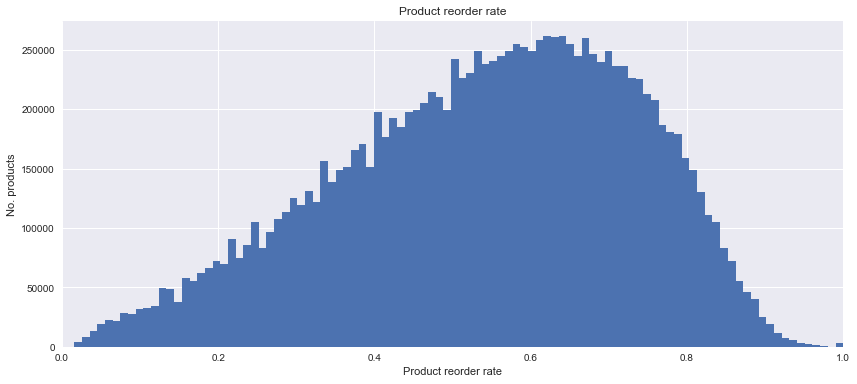

In [23]:
# Plot the reorded rate as a histogram
plt.figure(num=2,figsize=(14,6))
plt.hist(reorder_ratio['user_reorder_ratio'], bins=100)
plt.xlabel('Product reorder rate')
plt.ylabel('No. products')
plt.title('Product reorder rate')
plt.ticklabel_format(style='plain')
plt.xlim(0,1)
plt.show()

In [15]:
train = data[data['eval_set'] == 'train']
train['reordered'].fillna(0, inplace=True)
train.drop(['eval_set', 'product_id', 'order_id'], axis = 1, inplace = True)

test = data[data['eval_set'] == 'test']
test['reordered'].fillna(0, inplace=True)
test.drop(['eval_set', 'reordered'], axis = 1, inplace = True)

train.to_csv('my_train.csv', header = True, index = False)
test.to_csv('my_test.csv', header = True, index = False)

C:\Users\Hua\Anaconda3\lib\site-packages\pandas\core\generic.py:3549: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
C:\Users\Hua\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\Hua\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [10]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [34]:
train = pandas.read_csv('my_train.csv')
test = pandas.read_csv('my_test.csv')

capstone_train = pandas.merge(train, train_user, how='inner', on='user_id')
capstone_test = pandas.merge(train, test_user, how='inner', on='user_id')

del train 
gc.collect()

4798

In [27]:
X_train = capstone_train[capstone_train.columns.difference(['reordered'])]
y_train = capstone_train['reordered']

X_eval = capstone_test[capstone_test.columns.difference(['reordered'])]
y_eval = capstone_test['reordered']

In [29]:
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_eval = lgb.Dataset(X_eval, y_eval, reference = lgb_train)

params = {
    'task': 'train',
    'boosting_type': 'gbdt',              
    'objective': 'binary',
    'metric': {'binary_logloss', 'auc'},
    'num_iterations' : 1000,              
    'max_bin' : 100,                      
    'num_leaves': 512,                    
    'feature_fraction': 0.9,              
    'bagging_fraction': 0.95,
    'bagging_freq': 5,
    'min_data_in_leaf' : 200,             
    'learning_rate' : 0.1,
}

In [30]:
print('train LightGBM model ...')
lgb_model = lgb.train(params,
                lgb_train,
                num_boost_round = 200,     
                valid_sets = lgb_eval,     
                early_stopping_rounds=10) 

del lgb_train, X_train, y_train
gc.collect()

print('implement model to test data ...')
test['reordered'] = lgb_model.predict(test[test.columns.difference(['order_id', 'product_id'])], num_iteration = lgb_model.best_iteration)

training LightGBM model ...


C:\Users\Hua\Anaconda3\lib\site-packages\lightgbm\engine.py:100: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's auc: 0.826249	valid_0's binary_logloss: 0.625257
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.8277	valid_0's binary_logloss: 0.569756
[3]	valid_0's auc: 0.8287	valid_0's binary_logloss: 0.523723
[4]	valid_0's auc: 0.82897	valid_0's binary_logloss: 0.485084
[5]	valid_0's auc: 0.829182	valid_0's binary_logloss: 0.452386
[6]	valid_0's auc: 0.829443	valid_0's binary_logloss: 0.424522
[7]	valid_0's auc: 0.829628	valid_0's binary_logloss: 0.400715
[8]	valid_0's auc: 0.829777	valid_0's binary_logloss: 0.380189
[9]	valid_0's auc: 0.830014	valid_0's binary_logloss: 0.362589
[10]	valid_0's auc: 0.830265	valid_0's binary_logloss: 0.34727
[11]	valid_0's auc: 0.830469	valid_0's binary_logloss: 0.333963
[12]	valid_0's auc: 0.830575	valid_0's binary_logloss: 0.322422
[13]	valid_0's auc: 0.830757	valid_0's binary_logloss: 0.312377
[14]	valid_0's auc: 0.830999	valid_0's binary_logloss: 0.303637
[15]	valid_0's auc: 0.831098	valid_0's binary_logloss: 0.

In [31]:
prod_basket = dict()
for row in test.itertuples():
    if row.reordered > 0.20:
        try:
            prod_basket[row.order_id] += ' ' + str(row.product_id)
        except:
            prod_basket[row.order_id] = str(row.product_id)

for order in test.order_id:
    if order not in prod_basket:
        prod_basket[order] = 'None'

submit = pandas.DataFrame.from_dict(prod_basket, orient='index')

submit.reset_index(inplace=True)
submit.columns = ['order_id', 'products']
submit.to_csv('Output_for_Submission.csv', index=False)

formatting and writing to submission file ...
